In [1]:
# import the packages
import sys
import pickle
from collections import defaultdict

In [2]:
# add the path to the env
sys.path.append("./tools")
sys.path.append("./final_project/")

In [3]:
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data,test_classifier
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile,SelectKBest
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

/Users/renrui/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
# Load the dictionary containing the dataset
with open("./final_project/final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

## 1 Understanding the Dataset and Question

In [5]:
# total number of data points
print "Total number of the data points: %i\n" % len(data_dict)
# allocation across classes (POI/non-POI)
poi = 0
non_poi = 0
for key, values in data_dict.items():
    if values["poi"] == False:
        non_poi += 1
    elif values["poi"] == True:
        poi += 1
print "The number of the poi is %d\n" % poi
print "The number of the non-poi is %d\n" % non_poi
# number of features used
print "The number of features is %d in the dataset\n" % (len(data_dict.values()[0]) - 1)

Total number of the data points: 146

The number of the poi is 18

The number of the non-poi is 128

The number of features is 20 in the dataset



In [6]:
# feature that has missing values
feature_with_missing_values = set()
for value in data_dict.values():
    for key in value.keys():
        if value[key] == "NaN":
            feature_with_missing_values.add(key)

print "There are %i feature with missing values.\n" % len(feature_with_missing_values)
print "There is missing value about the feature:\n"
for i in feature_with_missing_values:
    print i

There are 20 feature with missing values.

There is missing value about the feature:

salary
to_messages
deferral_payments
total_payments
long_term_incentive
loan_advances
bonus
restricted_stock
restricted_stock_deferred
total_stock_value
shared_receipt_with_poi
from_poi_to_this_person
exercised_stock_options
from_messages
other
from_this_person_to_poi
deferred_income
expenses
email_address
director_fees


In [7]:
count_missing_value = {}
for key in feature_with_missing_values:
    count_missing_value[key] = 0
    
for value in data_dict.values():
    for key in feature_with_missing_values:
        if value[key] == "NaN":
            count_missing_value[key] += 1

print "The count of feature with missing values:\n"
tem_values = count_missing_value.values() # create variable to store the value
for value in sorted(count_missing_value.values(), reverse=True):
    index = tem_values.index(value)
    tem_values[index] = ""
    print "%s : %d" % (count_missing_value.keys()[index], count_missing_value.values()[index])

The count of feature with missing values:

loan_advances : 142
director_fees : 129
restricted_stock_deferred : 128
deferral_payments : 107
deferred_income : 97
long_term_incentive : 80
bonus : 64
to_messages : 60
shared_receipt_with_poi : 60
from_messages : 60
from_this_person_to_poi : 60
from_poi_to_this_person : 60
other : 53
salary : 51
expenses : 51
exercised_stock_options : 44
restricted_stock : 36
email_address : 35
total_payments : 21
total_stock_value : 20


In [8]:
person_with_missing_value = {}
for key, value in data_dict.items():
    person_with_missing_value[key] = sum([element == "NaN" for element in value.values()])
    
# print the top 20 person with missing value
print "The top 20 person with missing values:"
sort_person = sorted(person_with_missing_value.items(), lambda x, y: cmp(x[1], y[1]), reverse=True)
for i in range(0, 20):
    print "%s : %d" % (sort_person[i][0], sort_person[i][1])

The top 20 person with missing values:
LOCKHART EUGENE E : 20
WHALEY DAVID A : 18
WROBEL BRUCE : 18
THE TRAVEL AGENCY IN THE PARK : 18
GRAMM WENDY L : 18
WODRASKA JOHN : 17
CLINE KENNETH W : 17
WAKEHAM JOHN : 17
GILLIS JOHN : 17
SCRIMSHAW MATTHEW : 17
SAVAGE FRANK : 17
LOWRY CHARLES P : 16
CHAN RONNIE : 16
URQUHART JOHN A : 16
MENDELSOHN JOHN : 16
MEYER JEROME J : 16
GATHMANN WILLIAM D : 16
PEREIRA PAULO V. FERRAZ : 16
BLAKE JR. NORMAN P : 16
CHRISTODOULOU DIOMEDES : 16


### 1.1 Data Exploration


经整合后的数据中，包括的**数据点**数量为**146**；已经标识了**POI**人数为**18**人，**未标识POI**人数为**128**人；该数据集中拥有的** feature **数量为 **20** 个（ POI 不作为 feature 来统计）。

在数据集中有**缺失值的 feature **有 **20** 个，包括的 feature 为：salary，to_messages，deferral_payments，total_payments，long_term_incentive，loan_advances，bonus，restricted_stock，restricted_stock_deferred，total_stock_value，shared_receipt_with_poi，from_poi_to_this_person，exercised_stock_options，from_messages，other，from_this_person_to_poi，deferred_income，expenses，email_address，director_fees。

在数据点中，缺失值最多的 feature 是 **loan_advances**，共有 **142** 个人员在该 feature 上有缺失值；而在各人员中缺失值最多的是 **LOCKHART EUGENE E**，达到了 **20** 个 feature 有缺失值；此外从名称可以看出 **THE TRAVEL AGENCY IN THE PARK** 是一个组织，而非一个姓名

In [9]:
# explore the data point
for i in sorted(data_dict.keys()):
    print i

ALLEN PHILLIP K
BADUM JAMES P
BANNANTINE JAMES M
BAXTER JOHN C
BAY FRANKLIN R
BAZELIDES PHILIP J
BECK SALLY W
BELDEN TIMOTHY N
BELFER ROBERT
BERBERIAN DAVID
BERGSIEKER RICHARD P
BHATNAGAR SANJAY
BIBI PHILIPPE A
BLACHMAN JEREMY M
BLAKE JR. NORMAN P
BOWEN JR RAYMOND M
BROWN MICHAEL
BUCHANAN HAROLD G
BUTTS ROBERT H
BUY RICHARD B
CALGER CHRISTOPHER F
CARTER REBECCA C
CAUSEY RICHARD A
CHAN RONNIE
CHRISTODOULOU DIOMEDES
CLINE KENNETH W
COLWELL WESLEY
CORDES WILLIAM R
COX DAVID
CUMBERLAND MICHAEL S
DEFFNER JOSEPH M
DELAINEY DAVID W
DERRICK JR. JAMES V
DETMERING TIMOTHY J
DIETRICH JANET R
DIMICHELE RICHARD G
DODSON KEITH
DONAHUE JR JEFFREY M
DUNCAN JOHN H
DURAN WILLIAM D
ECHOLS JOHN B
ELLIOTT STEVEN
FALLON JAMES B
FASTOW ANDREW S
FITZGERALD JAY L
FOWLER PEGGY
FOY JOE
FREVERT MARK A
FUGH JOHN L
GAHN ROBERT S
GARLAND C KEVIN
GATHMANN WILLIAM D
GIBBS DANA R
GILLIS JOHN
GLISAN JR BEN F
GOLD JOSEPH
GRAMM WENDY L
GRAY RODNEY
HAEDICKE MARK E
HANNON KEVIN P
HAUG DAVID L
HAYES ROBERT E
HAYSLETT RODERIC

### 1.2 Outlier Investigation
结合以上对数据的探索，对数据进行如下处理：删除 loan_advances 的 feature、删除因缺失值较多的数据点 LOCKHART EUGENE E 、删除非人员姓名的对象 THE TRAVEL AGENCY IN THE PARK、此外数据中存在一个 TOTAL 的数据点，该数据点是所有数据的求和值，不能代表某个人，因此也需要删除 TOTAL 数据点

In [10]:
# remove the data points accordind by the data exploration
data_dict.pop("LOCKHART EUGENE E")
data_dict.pop("THE TRAVEL AGENCY IN THE PARK")
data_dict.pop("TOTAL")

for _, values in data_dict.items():
    values.pop("loan_advances")

## 2 Optimize Feature Selection/Engineering

In [11]:
# create a new feature according by the email recieved and the email sended
def new_feature(old_feature, condition_feature):
    if condition_feature == "NaN" or old_feature == "NaN":
        return "NaN"
    else:
        return old_feature * 1.0 / condition_feature
    
for values in data_dict.values():
    values["from_poi_ratio"] = new_feature(values["from_poi_to_this_person"], values["from_messages"])
    values["to_poi_ratio"] = new_feature(values["from_this_person_to_poi"], values["to_messages"])

### 2.1 Create new features
从已经完成的 mini project 以及从其他方面了解到到信息，可知在对数据集中是否有欺诈行为的人员判断中，和已知 POI 人员来往的邮件数量是一个重要的 feature。因此根据已有的 from_messages、from_poi_to_this_person、to_message、from_this_person_to_poi 的特征创建了新的 feature 即收发相关 POI 的信息占总体信息的比例，分别创建了一个 from_poi_ratio 和 to_poi_ratio 的 feature

In [12]:
# create a dataframe to fix the feature
df = pd.DataFrame(data_dict)
df = df.T

# del the feature email_address
df.drop("email_address", axis=1, inplace=True)

# conver the data type
for feature in df.columns:
    if feature == "poi":
        continue
    else:
        df[feature] = df[feature].astype("float64")
# fill the missing value with 0
df.fillna(0, inplace=True)


In [13]:
# seperate the data into the feature and label
data_features = df.drop("poi", axis=1)
data_label = df["poi"]

# use the selectkbest function to show the feature score
feature_selector = SelectKBest(k="all")
feature_selector.fit(data_features, data_label)

print "All the selected feature score by using SelectKBest function:\n"
all_feature_score = pd.DataFrame(feature_selector.scores_, index=data_features.columns.tolist(),columns=['score'])
print all_feature_score.sort_values('score',ascending=False)

All the selected feature score by using SelectKBest function:

                               score
exercised_stock_options    24.815080
total_stock_value          24.182899
bonus                      20.792252
salary                     18.289684
deferred_income            11.458477
long_term_incentive         9.922186
restricted_stock            9.212811
total_payments              8.772778
shared_receipt_with_poi     8.589421
expenses                    6.094173
from_poi_to_this_person     5.243450
from_poi_ratio              5.123946
other                       4.187478
to_poi_ratio                4.094653
from_this_person_to_poi     2.382612
director_fees               2.126328
to_messages                 1.646341
deferral_payments           0.224611
from_messages               0.169701
restricted_stock_deferred   0.065500


In [14]:
# use the 19 best feature to train the model
data_features.drop("restricted_stock_deferred", axis=1, inplace=True)

print "In the data set there are %d features used.\n" % len(data_features.columns)
print "The features are:\n"
for i in data_features.columns:
    print i

In the data set there are 19 features used.

The features are:

bonus
deferral_payments
deferred_income
director_fees
exercised_stock_options
expenses
from_messages
from_poi_ratio
from_poi_to_this_person
from_this_person_to_poi
long_term_incentive
other
restricted_stock
salary
shared_receipt_with_poi
to_messages
to_poi_ratio
total_payments
total_stock_value


### 2.2 Intelligently select features 
从数据集中，存在一个 email_address 的 feature，在实际应用中可以作为信息的 feature 可能性较低，因此直接删除；利用 SelectKBest 方法进行对所有剩余的 feature 查询 score，经验证新创建的两个 feature 取得了不错的分数分别为： from_poi_ratio 得到分数为 5.123946，to_poi_ratio 得到分数为 4.094653；另外最高分数为 exercised_stock_options，达到了 24.815080；最低分数 restricted_stock_deferred，分数为0.065500。最终选择删除最低分数的 feature。
综合以上所做的工作来看，用于机器学习的 feature 共计有 19 个，其中包括的 feature 有：bonus，deferral_payments，deferred_income，director_fees，exercised_stock_options，expenses，from_messages，from_poi_ratio，from_poi_to_this_person，from_this_person_to_poi，long_term_incentive，other，restricted_stock，salary，shared_receipt_with_poi，to_messages，to_poi_ratio，total_payments，total_stock_value 。此外 选择了一个 poi 作为 label。

Plot the non-label feature without be scaled


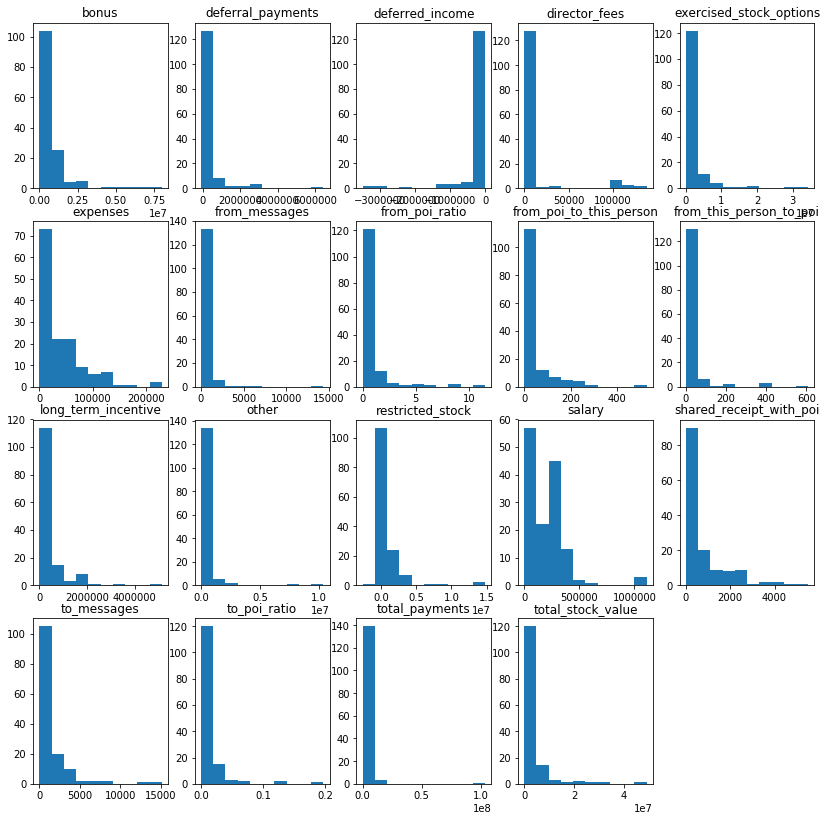

In [15]:
# plot the non-label feature
print "Plot the non-label feature without be scaled"
plt.figure(1, figsize=(14,14))
fig = 1
for feature in data_features.columns:
    plt.subplot(4, 5, fig)
    plt.hist(data_features[feature])
    plt.title(feature)
    fig += 1 
plt.show()  

In [16]:
# scaled the feature
new_data_features = data_features.applymap(lambda x: np.log(abs(x)) if x != 0 else 0)

Plot the non-label feature scaled


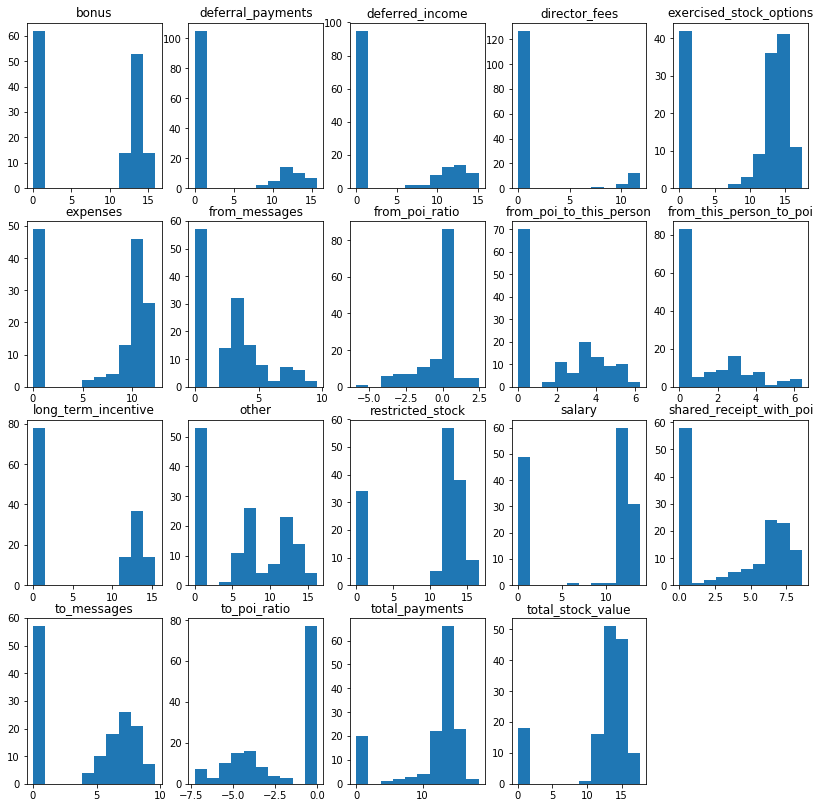

In [17]:
# plot the non-label feature
print "Plot the non-label feature scaled"
plt.figure(1, figsize=(14,14))
fig = 1
for feature in new_data_features.columns:
    plt.subplot(4, 5, fig)
    plt.hist(new_data_features[feature])
    plt.title(feature)
    fig += 1 
plt.show()  

### 2.3 Properly scale features 
从未进行缩放的 feature 展示的直方图中，可以看出大部分 feature 的数据分布都呈现出偏斜分布。通过 numpy 中的对数函数进行转换，获得到相关的直方图多数转换为正太分布——因为以上 feature 都是数值类型的，将其缩放一方面可以加快运行速度也同时避免因为某些 feature 的数值过大，导致的表现出权重过高的特点。因此在后续分析中，将暂时保留对数缩放数据，其他缩放方式，将在后续继续分析的过程中进行调试。

## 3 Pick and Tune an Algorithm

In [18]:
# concate the features and the label
log_data_feature = pd.concat([data_label, new_data_features], axis=1).to_dict(orient="index")
# origin_data_feature = pd.concat([data_label, data_features], axis=1).to_dict(orient="index")

# get the feature list
feature_list = ["poi"] + data_features.columns.tolist()

# get the data by using featureFormat
log_data = featureFormat(log_data_feature, feature_list, sort_keys=True)
log_labels, log_features = targetFeatureSplit(log_data)

# data = featureFormat(origin_data_feature, feature_list, sort_keys=True)
# labels, features = targetFeatureSplit(data)

In [19]:
# create a dict about algorithm and algorithm parameters
algorithms_dict = {
    "GaussianNB" : GaussianNB(),
    "LogisticRegression" : LogisticRegression(class_weight="balanced", random_state=36),
    "SVC": SVC(class_weight='balanced', random_state=36),
    "DecisionTreeClassifier":DecisionTreeClassifier(class_weight='balanced', random_state=36),
    "RandomForestClassifier": RandomForestClassifier(class_weight='balanced', random_state=36),
    "AdaBoostClassifier":AdaBoostClassifier(random_state=36)
}
algorithm_parameters_dict = {
    "GaussianNB": {},
    "LogisticRegression" : {
        "penalty": ["l1", "l2"],
        "C":[0.1, 1.0, 10., 100., 1000., 10000.],
        "max_iter":[50, 100, 200, 300]
    },
    "SVC": {
        "C": [0.1, 1.0, 10., 100., 1000.],
        "kernel": ["linear", "poly", "rbf", "sigmoid"], 
        "gamma": [0.01, 0.1, 1.0, 10., 100., 1000.]
    },
    "DecisionTreeClassifier":{
        "criterion": ["gini", "entropy"],
        "min_samples_split":[2, 8, 15, 20],
        "min_samples_leaf": [1, 2, 4]
    },
    "RandomForestClassifier": {
        "n_estimators": [2, 5, 10, 50],
        "criterion": ["gini", "entropy"],
        "min_samples_split":[2, 8, 15, 20],
        "min_samples_leaf": [1, 2, 4]
    },
    "AdaBoostClassifier":{
        "n_estimators": [2, 5, 10, 50],
        "learning_rate": [0.2, 0.6, 1.]
    }
}

### 3.1 Pick an algorithm
初始选择来了多种算法进行测试，其中包括 LogisticRegression，RandomForestClassifier，GaussianNB，AdaBoostClassifier，SVC，DecisionTreeClassifier 等 6 种算法进行尝试，并且选用了已经对数方式进行特征缩放的数据集进行分析。

In [20]:
# call the algorithm
def call_algorithm(algorithms, all_parameters, algorithm_name):
    model = GridSearchCV(algorithms[algorithm_name], all_parameters[algorithm_name])
    return model

In [21]:
best_algorithm = None
best_algorithm_score = 0
for algorithm_name in algorithms_dict.keys():
    print "The algorithm is %s:" % algorithm_name
    if algorithm_name == "GaussianNB":
        print test_classifier(algorithms_dict[algorithm_name], log_data_feature, feature_list)
        continue
    model = call_algorithm(algorithms_dict, algorithm_parameters_dict, algorithm_name)
    model.fit(new_data_features, data_label)
    
    print "In the algorithm %s The best parameters is :" % algorithm_name
    print model.best_estimator_
    print test_classifier(model.best_estimator_, log_data_feature, feature_list)    
    if model.best_score_ > best_algorithm_score:
        best_algorithm_score = model.best_score_
        best_algorithm = model.best_estimator_

The algorithm is LogisticRegression:
In the algorithm LogisticRegression The best parameters is :
LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=36,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=36,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
	Accuracy: 0.83600	Precision: 0.41756	Recall: 0.58250	F1: 0.48643	F2: 0.53985
	Total predictions: 15000	True positives: 1165	False positives: 1625	False negatives:  835	True negatives: 11375

None
The algorithm is RandomForestClassifier:
In the algorithm RandomForestClassifier The best parameters is :
RandomForestClassifier(bootstrap=True, class_weight='ba

### 3.2 Discuss parameter tuning and its importance & Tune the algorithm
初始分析数据，使用了对数方式对数据进行缩放，除了 GaussianNB 算法其他 6 种算法均使用了 GridSearchCV 来对参数进行调整。经过以上步骤进行分析，其中有两种算法表现比较良好，分别是：LogisticRegression 和 SVC，具体结果如下：

```
    The algorithm is LogisticRegression:
    In the algorithm LogisticRegression The best parameters is :
    LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
              fit_intercept=True, intercept_scaling=1, max_iter=100,
              multi_class='ovr', n_jobs=1, penalty='l1', random_state=36,
              solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
    LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
              fit_intercept=True, intercept_scaling=1, max_iter=100,
              multi_class='ovr', n_jobs=1, penalty='l1', random_state=36,
              solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
        Accuracy: 0.83600   Precision: 0.41756  Recall: 0.58250 F1: 0.48643 F2: 0.53985
        Total predictions: 15000    True positives: 1165    False positives: 1625   False negatives:  835   True negatives: 11375
        
    The algorithm is SVC:
    In the algorithm SVC The best parameters is :
    SVC(C=10.0, cache_size=200, class_weight='balanced', coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
      max_iter=-1, probability=False, random_state=36, shrinking=True,
      tol=0.001, verbose=False)
    SVC(C=10.0, cache_size=200, class_weight='balanced', coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
      max_iter=-1, probability=False, random_state=36, shrinking=True,
      tol=0.001, verbose=False)
        Accuracy: 0.84087   Precision: 0.42783  Recall: 0.57350 F1: 0.49007 F2: 0.53693
        Total predictions: 15000    True positives: 1147    False positives: 1534   False negatives:  853   True negatives: 11466
```

## 4 Validate and Evaluate

### 4.1 Usage of Evaluation Metrics & Algorithm Performance
本次项目中使用 precision 和 recall 来对项目对算法进行评估。precision 指的是被正确检测到的对象（ TP ）占所有实际所有检测对象（ TP + FP ）的比例 ${\frac{TP}{TP\ +\ FP}}$；而 recall 指的是被正确检测到的对象（ TP ）占可被检测到的对象（ TP + FN ）的比例 ${\frac{TP}{TP\ +\ FN}}$。利用 tester.py 模块来评估 LogisticRegression 和 SVC 这两个算法，得到的结果都比较理想，其中 SVC 算法达到的最好的结果，其 precision 达到了 0.42783，recall 值达到了0.57350

### 4.2 Discuss validation and its importance & Validation Strategy
机器学习中，使用验证是通过对数据集进行划分训练数据集和测试数据集，以相关数据集不同划分进行训练和测试，以验证算法和数据的拟合和泛化情况。本次项目中，使用了 GridSearchCV 中使用了默认的 CV 参数（默认值为 3-fold ）来进行交叉验证。考虑到结果单独用 precision 和 recall 容易出现因过度关注该指标而导致另一个指标出现过低的情况，因此可以通过 F1 来评估算法的结果。 F1 是通过 precision 和 recall 的调和平均值来计算得到的，其计算方式如下： ${\frac{2}{F1}\ =\ {\frac{1}{precision}\ +\ \frac{1}{recall}}}$。利用 F1 来评价已经得到的算法结果，可知 LogisticRegression 和 SVC 这两个算法得到的结果是比较理想的。

## 5 拓展
因为以上项目是初始的模式，以下将根据根据机器学习的思路，对原始数据集进行新的尝试。

可用于扩展的数据

data_dict #原始数据——已经完成了删除feature 和异常值
new_feature # 创建一个新的百分比特征
call_algorithm # 调用最佳算法
缺失值可处理的方式 "mean", "median", "most_frequent"

loan_advances** 的 feature；删除因缺失值较多的数据点 **LOCKHART EUGENE E** 、删除非人员姓名的对象 **THE TRAVEL AGENCY IN THE PARK**、此外数据中存在一个 **TOTAL** 的数据点，该数据点是所有数据的求和值，不能代表某个人，因此也需要删除 **TOTAL** 数据点


In [22]:
# assign the data_dict to a new variable
import copy
dataset = copy.deepcopy(data_dict)

# create the new feature about the messages ratio in the original data
# remove the feature email_address with much more missing value
for item in dataset.values():
    item["from_poi_ratio"] = new_feature(item["from_poi_to_this_person"], item["from_messages"])
    item["to_poi_ratio"] = new_feature(item["from_this_person_to_poi"], item["to_messages"])
    item.pop("email_address")

In [23]:
# fix the missing value
def value_imputation(data, strategy=None, missing_values="NaN"):
    if strategy not in ["mean", "median", "most_frequent"]:
        print "The strategy is incorrect."
    else:
        df = pd.DataFrame(data)
        df = df.T
        imputor = Imputer(missing_values=missing_values, strategy=strategy, axis=1)
        imputed_data = imputor.fit_transform(df.values)
        
        convert_df = pd.DataFrame(imputed_data, columns=df.columns, index=df.index)
        converted_data = convert_df.to_dict(orient="index")
        return converted_data

In [24]:
# split the data into the labels and the features
def feature_label_split(data, feature_list=feature_list):
    labels, features = targetFeatureSplit(featureFormat(data, feature_list, sort_keys=True))
    return labels, features

In [25]:
# select the best feature and these name
def feature_selected(k_best, features, labels, feature_list=feature_list):    
    # select feature
    selector = SelectKBest(k=k_best)
    selected_features = selector.fit_transform(features, labels)
    selected_feature_list = [feature_list[i+1] for i in selector.get_support(indices=True)]

    # print the result
    print "The top %d feature selected is:" % k_best
    for feature in selected_feature_list:
        print feature
    # return the result    
    return selected_features, selected_feature_list

In [26]:
# scale the feature
def scale_features(features, scaled_method=None):
    scaler = scaled_method
    scaled_features = scaler.fit_transform(features)
    
    return scaled_features

In [27]:
algorithms_dict = {
    "GaussianNB" : GaussianNB(),
    "LogisticRegression" : LogisticRegression(class_weight="balanced", random_state=36),
    "DecisionTreeClassifier":DecisionTreeClassifier(class_weight='balanced', random_state=36),
    "RandomForestClassifier": RandomForestClassifier(class_weight='balanced', random_state=36),
    "AdaBoostClassifier":AdaBoostClassifier(random_state=36)
}
algorithm_parameters_dict = {
    "GaussianNB": {},
    "LogisticRegression" : {
        "penalty": ["l1", "l2"],
        "C":[0.1, 1.0, 10., 100., 1000., 10000.],
        "max_iter":[50, 100, 200, 300]
    },
    "DecisionTreeClassifier":{
        "criterion": ["gini", "entropy"],
        "min_samples_split":[2, 8, 15, 20],
        "min_samples_leaf": [1, 2, 4]
    },
    "RandomForestClassifier": {
        "n_estimators": [2, 5, 10, 50],
        "criterion": ["gini", "entropy"],
        "min_samples_split":[2, 8, 15, 20],
        "min_samples_leaf": [1, 2, 4]
    },
    "AdaBoostClassifier":{
        "n_estimators": [2, 5, 10, 50],
        "learning_rate": [0.2, 0.6, 1.]
    }
}

In [28]:
# create the dataset to train the algorithm
def train_algorithm(data, strategy, k_best, scaled_method, algorithms_dict=algorithms_dict):
    print "Use the strategy %s to convert the data." % strategy
    # convert the data
    converted_data = value_imputation(data, strategy=strategy)
    # get the feature list which will be used
    feature_list = [key for key in converted_data.values()[0].keys() if key != "poi"]

    feature_list.insert(0, "poi") # inset the the poi in the front

    # split the data into the labels and the features
    labels, features = feature_label_split(converted_data, feature_list)

    # select the top feature
    selected_features, selected_feature_list = feature_selected(k_best, features, labels)
    
    selected_feature_list_poi = selected_feature_list.insert(0, "poi")
    
    # scale the features
    if scaled_method != None:
        scaled_selected_features = scale_features(selected_features, scaled_method=scaled_method)
    else:
        scaled_selected_features = selected_features
    
    # train the algorithm
    for  algorithm_name in algorithms_dict.keys():
        print "The algorithm is %s:" % algorithm_name

        if algorithm_name == "GaussianNB":
            print test_classifier(algorithms_dict[algorithm_name], dataset, selected_feature_list)
        else:
            model = call_algorithm(algorithms_dict, algorithm_parameters_dict, algorithm_name)
            model.fit(scaled_selected_features, labels)

            print "In the algorithm %s The best parameters and the accuracy are :" % algorithm_name
            print test_classifier(model.best_estimator_, dataset, selected_feature_list)

In [30]:
for i in range(6, 19):
    train_algorithm(dataset, "median", i, MinMaxScaler())

Use the strategy median to convert the data.
The top 6 feature selected is:
director_fees
from_messages
from_poi_to_this_person
other
to_poi_ratio
total_stock_value
The algorithm is RandomForestClassifier:
In the algorithm RandomForestClassifier The best parameters and the accuracy are :
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=2, n_jobs=1, oob_score=False, random_state=36,
            verbose=0, warm_start=False)
	Accuracy: 0.85387	Precision: 0.31955	Recall: 0.08500	F1: 0.13428	F2: 0.09962
	Total predictions: 15000	True positives:  170	False positives:  362	False negatives: 1830	True negatives: 12638

None
The algorithm is GaussianNB:
GaussianNB(priors=None)
	Accuracy: 0.29433	Precision: 0.14662

In the algorithm RandomForestClassifier The best parameters and the accuracy are :
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=36,
            verbose=0, warm_start=False)
	Accuracy: 0.86033	Precision: 0.39560	Recall: 0.09000	F1: 0.14664	F2: 0.10645
	Total predictions: 15000	True positives:  180	False positives:  275	False negatives: 1820	True negatives: 12725

None
The algorithm is GaussianNB:
GaussianNB(priors=None)
	Accuracy: 0.72887	Precision: 0.22015	Recall: 0.40650	F1: 0.28561	F2: 0.34764
	Total predictions: 15000	True positives:  813	False positives: 2880	False negatives: 1187	True negatives: 10120

None
The algorithm is LogisticRegression:
In the a

In the algorithm RandomForestClassifier The best parameters and the accuracy are :
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=2, n_jobs=1, oob_score=False, random_state=36,
            verbose=0, warm_start=False)
	Accuracy: 0.84253	Precision: 0.35543	Recall: 0.22250	F1: 0.27368	F2: 0.24049
	Total predictions: 15000	True positives:  445	False positives:  807	False negatives: 1555	True negatives: 12193

None
The algorithm is GaussianNB:
GaussianNB(priors=None)
	Accuracy: 0.78907	Precision: 0.29876	Recall: 0.43200	F1: 0.35323	F2: 0.39662
	Total predictions: 15000	True positives:  864	False positives: 2028	False negatives: 1136	True negatives: 10972

None
The algorithm is LogisticRegression:
In the

In the algorithm RandomForestClassifier The best parameters and the accuracy are :
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=36,
            verbose=0, warm_start=False)
	Accuracy: 0.85320	Precision: 0.39278	Recall: 0.18500	F1: 0.25153	F2: 0.20689
	Total predictions: 15000	True positives:  370	False positives:  572	False negatives: 1630	True negatives: 12428

None
The algorithm is GaussianNB:
GaussianNB(priors=None)
	Accuracy: 0.81460	Precision: 0.32910	Recall: 0.37600	F1: 0.35099	F2: 0.36558
	Total predictions: 15000	True positives:  752	False positives: 1533	False negatives: 1248	True negatives: 11467

None
The algorithm is LogisticRegression:
In the a

In the algorithm RandomForestClassifier The best parameters and the accuracy are :
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=36,
            verbose=0, warm_start=False)
	Accuracy: 0.84240	Precision: 0.37785	Recall: 0.28150	F1: 0.32264	F2: 0.29663
	Total predictions: 15000	True positives:  563	False positives:  927	False negatives: 1437	True negatives: 12073

None
The algorithm is GaussianNB:
GaussianNB(priors=None)
	Accuracy: 0.82107	Precision: 0.35066	Recall: 0.40150	F1: 0.37436	F2: 0.39018
	Total predictions: 15000	True positives:  803	False positives: 1487	False negatives: 1197	True negatives: 11513

None
The algorithm is LogisticRegression:
In the

## Reference
1. [python 2.7 - 绘图报错](https://stackoverflow.com/questions/28393103/typeerror-cannot-perform-reduce-with-flexible-type)
2. [PANDAS 数据合并与重塑](http://blog.csdn.net/stevenkwong/article/details/52528616)
3. [模型评估与验证 | RyannnG‘s Blog](https://ryannng.github.io/2016/12/12/%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E6%80%BB%E7%BB%93-%E6%A8%A1%E5%9E%8B%E8%AF%84%E4%BC%B0%E4%B8%8E%E9%AA%8C%E8%AF%81/)
4. [机器学习性能评估指标](http://charleshm.github.io/2016/03/Model-Performance/#fnref:1)
5. [4.3. 数据预处理 — scikit-learn 0.18.1 documentation](http://sklearn.lzjqsdd.com/modules/preprocessing.html)
6. [supernova16/DAND-P5-Machine-Learning: 通过机器学习来识别安然事件中的欺诈嫌疑人](https://github.com/supernova16/DAND-P5-Machine-Learning)